# 使用 Trident Chemwidgets 进行交互式模型评估

在本教程中，我们将在[*图卷积的介绍* 教程](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_Graph_Convolutions.ipynb)的基础上，向你展示如何使用 [Trident Chemwidgets](https://github.com/tridentbio/trident-chemwidgets) （TCW）包与你训练的模型进行交互和测试。

在新数据上评估模型，包括极端案例，是模型部署的关键步骤。然而，生成新分子以交互方式进行测试很少是直接的。TCW 提供了一些工具来帮助对更大的数据集进行子集化，并绘制新的分子对模型进行测试。你可以在 [这里](https://www.trident.bio/trident-chemwidgets/html/index.html) 找到 Trident Chemwidgets 库的完整文档。

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Interactive_model_evaluation_with_Trident_Chemwidgets.ipynb)

# 准备

In [ ]:
!pip install tensorflow deepchem trident-chemwidgets seaborn

对于本教程，你需要 Trident Chemwidgets 0.2.0 或更高版本。我们可以用下面的命令检查安装的版本：

In [1]:
import trident_chemwidgets as tcw
print(tcw.__version__)

0.2.1


在本教程中，我们将使用惯用的 `tcw` 来称 Trident Chemwidgets 包中的类。

# 探索数据

首先，我们将加载 Tox21 数据集并提取预定义的训练、验证和测试拆分。

In [2]:
import deepchem as dc

tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

然后，我们可以使用 RDKit 为每个训练示例计算一些额外的特征。具体来说，我们将计算每个分子的 [logP](https://en.wikipedia.org/wiki/Partition_coefficient) 和 [分子量](https://en.wikipedia.org/wiki/Molecular_mass)，并在 dataframe 中返回此新数据。

In [3]:
import rdkit.Chem as Chem
from rdkit.Chem.Crippen import MolLogP
from rdkit.Chem.Descriptors import MolWt
import pandas as pd

data = []

for dataset, split in zip(datasets, ['train', 'valid', 'test']):
    for smiles in dataset.ids:
        mol = Chem.MolFromSmiles(smiles)
        logp = MolLogP(mol)
        mwt = MolWt(mol)
        data.append({
            'smiles': smiles,
            'logp': logp,
            'mwt': mwt,
            'split': split
        })
        
mol_data = pd.DataFrame(data)

mol_data.head()

[15:36:55] WARNING: not removing hydrogen atom without neighbors


,smiles,logp,mwt,split
0,CC(O)(P(=O)(O)O)P(=O)(O)O,-0.9922,206.027,train
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,4.8172,290.444,train
2,OC[C@H](O)[C@@H](O)[C@H](O)CO,-2.9463,152.146,train
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2],2.1911,351.802,train
4,CC(C)COC(=O)C(C)C,1.8416,144.214,train


## 一维分布

我们可以用直方图来检查一维分布。与 Matplotlib 或 Seaborn 等静态绘图库中的直方图不同，TCW 直方图提供了交互功能。TCW 支持对数据进行子集设置，图库中在绘图旁边绘制化学结构，并保存对 dataframe 子集部分的引用。不幸的是，这种交互性是以可移植性为代价的，所以除了提供生成交互式视觉效果的代码外，我们还在本教程中包含了截屏。如果你自己运行本教程（本地或在 Colab 上），你将能够显示完整的演示图并与之交互。

在下面的图中，你可以看到左边的合并的数据集的分子量分布的直方图。如果在活动小部件中的绘图区域内单击并拖动，则可以将分布的一部分划分为子集，以便进一步检查。所选部分的背景将变为灰色，所选数据点将在图的柱状图中显示为蓝绿色。直方图小部件的 x 轴与数值或日期数据类型兼容，这使得它成为基于性质或收集实验数据的日期拆分机器学习数据集的方便选择。

<img src='.\附件\Histogram.png' alt="Histogram example" width="1000"/>

要生成小部件的交互式示例，运行下一个单元格：

In [4]:
hist = tcw.Histogram(data=mol_data, smiles='smiles', x='mwt')
hist

Histogram(data={'points': [{'smiles': 'CC(O)(P(=O)(O)O)P(=O)(O)O', 'x': 206.027, 'index': 0}, {'smiles': 'CC(C…

如果你通过点击和拖动选择数据的子集，你可以通过按下图下方的 `SHOW STRUCTURES` 按钮在右侧的图库中查看所选的结构。你可以通过按下 `SAVE SELECTION` 获取原来的 dataframe 的子集并访问其 `hist.selection` 属性如同下面所示。该工作流对于基于单一维度的数据拆分等应用非常方便。

In [ ]:
hist.selection

,smiles,logp,mwt,split


## Two- or three-dimensional distributions

除了直方图，TCW还提供了绘制散点图的类。Scatter 类在比较二维或三维或数据时非常有用。从 v0.2.0 开始，TCW Scatter 支持使用 x 轴和 y 轴以及每个点的颜色( `hue` 关键字)来表示连续或离散变量。就像直方图示例一样，你可以在绘图区域内单击和拖动以沿 x 轴和 y 轴进行子集。Scatter 组件还支持 x、y 和 hue 轴上的日期。

在下面的图像中，我们选择了分子量值较大的数据集的一部分，但训练示例很少（以橙色显示的点），以演示 Scatter 小部件如何用于离群值识别。除了通过边界框进行选择外，你还可以将鼠标悬停在单个点上以显示底层结构的绘图。

<img src='.\附件\Scatter.png' alt="Scatter example" width="1000"/>

要生成小部件的交互式示例，运行下一个单元格：

In [ ]:
scatter = tcw.Scatter(data=mol_data, smiles='smiles', x='mwt', y='logp', hue='split')
scatter

Scatter(data={'points': [{'smiles': 'CC(O)(P(=O)(O)O)P(=O)(O)O', 'x': 206.027, 'y': -0.9922000000000002, 'hue'…

如果你通过点击和拖动选择数据的子集，你可以通过按下图下方的 `SHOW STRUCTURES` 按钮在右侧的图库中查看所选的结构。你可以通过按下 `SAVE SELECTION` 获取原来的 dataframe 的子集并访问其 `scatter.selection` 属性如同下面所示。

In [7]:
scatter.selection

,smiles,logp,mwt,split


# 训练一个 GraphConvModel

现在我们已经了解了训练数据，我们可以训练 GraphConvModel 来预测12个 Tox21 类。我们将完全复制[*介绍图形卷积*教程](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Introduction_to_Graph_Convolutions.ipynb)中的训练过程。我们将训练50次，就像在最初的教程。

In [8]:
# The next line filters tensorflow warnings relevant to memory consumption.
# To see these warnings, comment the next line.
#import warnings; warnings.filterwarnings('ignore')

# Now we'll set the tensorflow seed to make sure the results of this notebook are reproducible
import tensorflow as tf; tf.random.set_seed(27)

n_tasks = len(tasks)
model = dc.models.GraphConvModel(n_tasks, mode='classification')
model.fit(train_dataset, nb_epoch=50)

2022-06-29 15:37:03.915828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.2661594772338867

现在我们有了一个训练过的模型，我们可以检查训练和测试数据集的 AUROC 值：

In [9]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
print(f'Training set score: {model.evaluate(train_dataset, [metric], transformers)["roc_auc_score"]:.2f}')
print(f'Test set score: {model.evaluate(test_dataset, [metric], transformers)["roc_auc_score"]:.2f}')

Training set score: 0.97
Test set score: 0.68


正如在最初的教程中一样，我们看到模型在预定义的训练/测试分割中表现得相当好。现在我们将使用这个模型来评估训练分布之外的化合物，就像我们在真实的药物发现场景中所做的那样。

# 在新数据上评估模型

在生产中部署机器学习模型的第一个具有挑战性的步骤是在新数据上评估它。在这里，新数据既指初始 train/val/test 分布之外的数据，也指可能尚未处理并与模型一起使用的数据。

我们可以使用 TCW 提供的 JSME 小部件再次快速测试我们的模型。我们将从一个已知的治疗分子开始：布洛芬。我们可以看到，布洛芬不包括在我们评估模型的任何数据集中：

In [10]:
print(f"Ibuprofen structure in Tox21 dataset: {'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O' in mol_data['smiles']}")

Ibuprofen structure in Tox21 dataset: False


为了模拟药物发现应用，假设你是一名化学家，任务是识别从布洛芬衍生出的潜在新疗法。理想情况下，你测试的分子毒性应该是有限的。你刚刚开发了上面的模型来根据 Tox21 数据预测毒理结果，现在你想使用它对你的衍生物进行一些初步筛选。这类任务的标准工作流程可能包括在 ChemDraw 等程序中绘制分子，导出为 SMILES 格式，导入到笔记本中，然后准备数据并加载到模型。

有了 TCW，我们可以使用 [JSME](https://jsme-editor.github.io/help.html) 小部件在笔记本中直接绘制分子并转换为 SMILES，从而简化工作流的前几个步骤。我们甚至可以使用 `base_smiles` 参数来指定基本分子结构，这对于生成衍生物非常有用。这里我们将把 base_smiles 值设置为 `'CC(C)CC1=CC=C(C=C1)C(C)C(=O)O'` ，即布洛芬的 SMILES 字符串。下面是使用 JSME 生成的一些衍生分子来测试我们的毒性模型的截图。

<img src=".\附件\JSME.png" alt="JSME example" width="1000"/>

要生成你自己的衍生物，请运行下面的单元格。要向保存的集合中添加 SMILES 字符串，请单击界面下方的 `ADD TO SMILES LIST` 按钮。如果你想重新生成原来的基本分子，在本例中是布洛芬，点击界面下方的 `RESET TO BASE SMILES` 按钮。通过使用这个按钮，可以很容易地从共享的起始结构生成不同的衍生物。继续制作一些布洛芬衍生物来测试毒理模型：

In [11]:
jsme = tcw.JSME(base_smiles='CC(C)CC1=CC=C(C=C1)C(C)C(=O)O')
jsme

JSME(base_smiles='CC(C)CC1=CC=C(C=C1)C(C)C(=O)O')

你可以使用 `jsme.smiles` 方法访问smiles。这个调用将返回已添加到小部件的 SMILES 列表中的 SMILES 字符串的列表（在 JSME 界面右侧的分子图库中显示的那些字符串）。

In [12]:
print(jsme.smiles)

[]


为了确保笔记本的其余部分正确运行，如果你没有使用小部件定义自己的集合，那么下面的单元格将新的测试 SMILES 列表设置为上面屏幕截图中的值。否则，它就会用你画的分子。

In [13]:
# This cell will provide a preset list of SMILES strings in case you did not create your own.
if len(jsme.smiles) > 1:
    drawn_smiles = jsme.smiles
else:
    drawn_smiles = [
        'CC(C)Cc1ccc(C(C)C(=O)O)cc1',
        'CC(C)C(S)c1ccc(C(C)C(=O)O)cc1',
        'CCSC(c1ccc(C(C)C(=O)O)cc1)C(C)CC',
        'CCSC(c1ccc(C(C)C(=O)O)cc1)C(C)C(=O)O',
        'CC(C(=O)O)c1ccc(C(S)C(C)C(=O)O)cc1'
    ]

接下来，我们必须创建一个与我们的模型兼容的数据集来测试这些新分子。

In [14]:
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.InMemoryLoader(tasks=list(train_dataset.tasks), featurizer=featurizer)
dataset = loader.create_dataset(drawn_smiles, shard_size=1)

最后，我们可以在这里生成对正结果的预测，并将其绘制出来。

<AxesSubplot:>

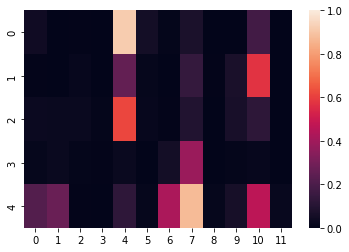

In [15]:
predictions = model.predict(dataset, transformers)[:, :, 1]

import seaborn as sns
sns.heatmap(predictions, vmin=0, vmax=1)

现在我们可以得到预测的毒性最大的化合物/测定结果，以供进一步检查。下面我们提取最高的预测阳性命中值（毒性最强），并显示化验名称、SMILES 字符串和结构图像。

Most toxic result (predicted): NR-ER, CC(C)Cc1ccc(C(C)C(=O)O)cc1


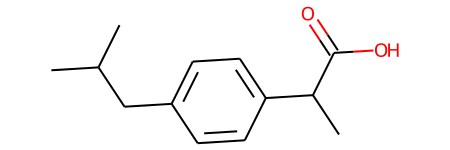

In [16]:
import numpy as np

mol_idx, assay_idx = np.unravel_index(predictions.argmax(), predictions.shape)
smiles = drawn_smiles[mol_idx]

print(f'Most toxic result (predicted): {train_dataset.tasks[assay_idx]}, {smiles}')
mol = Chem.MolFromSmiles(smiles)
mol

# Interpreting the model's predictions

通常，仅凭预测不足以决定是否进行昂贵的实验。我们可能还需要一些或多个允许我们解释模型输出的指标。

在教程[基于图卷积 QSAR 模型计算原子对分子的贡献](https://aidd-tutorial.readthedocs.io/zh_CN/latest/%E5%8E%9F%E5%AD%90%E5%AF%B9%E5%88%86%E5%AD%90%E7%9A%84%E8%B4%A1%E7%8C%AE.html)的基础上，我们可以计算分子中每个原子对预测输出值的相对贡献。这种归因策略使我们能够确定化学家可能认为重要的分子特征和那些最影响预测的分子特征是否一致。如果化学家的解释和模型的解释指标是一致的，这可能表明模型很适合手头的任务。然而，反过来也不一定是真的。一个模型可能有能力做出一个训练有素的化学家无法完全理解的准确预测。这只是机器学习从业者工具箱中的一个工具。

我们将首先为 `ConvMolFeaturizer` 使用内置的 `per_atom_fragmentation` 参数。这将生成一个 ConvMol 对象列表，每个对象都是删除了一个原子的分子。

In [17]:
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=True)
mol_list = featurizer(smiles)
loader = dc.data.InMemoryLoader(tasks=list(train_dataset.tasks),
                                featurizer=dc.feat.DummyFeaturizer())
dataset = loader.create_dataset(mol_list[0], shard_size=1)

然后，我们可以通过模型运行这些预测，并检索上一部分指定的分子的预测值和化验结果。

In [18]:
full_molecule_prediction = predictions[mol_idx, assay_idx]
fragment_predictions = model.predict(dataset, transformers)[:, assay_idx, 0]
contributions = pd.DataFrame({
    'Change in predicted toxicity': 
    (full_molecule_prediction - fragment_predictions).round(3)
})

我们可以使用 TCW 的 InteractiveMolecule 小部件将贡献分数叠加在分子本身上，使我们能够轻松地评估每个原子对最终预测的相对重要性。如果单击其中一个原子，就可以在结构右侧显示的卡片中检索贡献数据。在这个面板中，你还可以选择一个变量来为图中的原子上色。

<img src=".\附件\InteractiveMolecule.png" alt="InteractiveMolecule example" width="1000"/>

你可以通过运行下面的单元格来生成交互式小部件。

In [19]:
tcw.InteractiveMolecule(smiles, data = contributions)

InteractiveMolecule(data=[{'Change in predicted toxicity': 0.5529999732971191}, {'Change in predicted toxicity…

# 结束

在本教程中，我们学习了如何将 Trident Chemwidgets 合并到基于 deepchem 的机器学习工作流中。虽然 TCW 是根据分子机器学习工作流程建立的，但该库也适用于一般化学信息学笔记本。 

## Star Trident Chemwidgets on [GitHub](https://github.com/tridentbio/trident-chemwidgets)
If you find the Trident Chemwidgets package helpful please give it a ⭐️ on GitHub. Starring the project helps it grow and find new audiences.

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!